In [1]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'   # better inline figure resolution
plt.style.use('tableau-colorblind10')

In [11]:
locations = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])
normal = lambda location : np.random.normal(loc = location, scale = 0.5, size=(100, 2))
data = np.array([normal(location) for location in locations])
data = np.concatenate(data, axis=0)
labels = np.array([0] * 3 * 100 + [1] * 100)

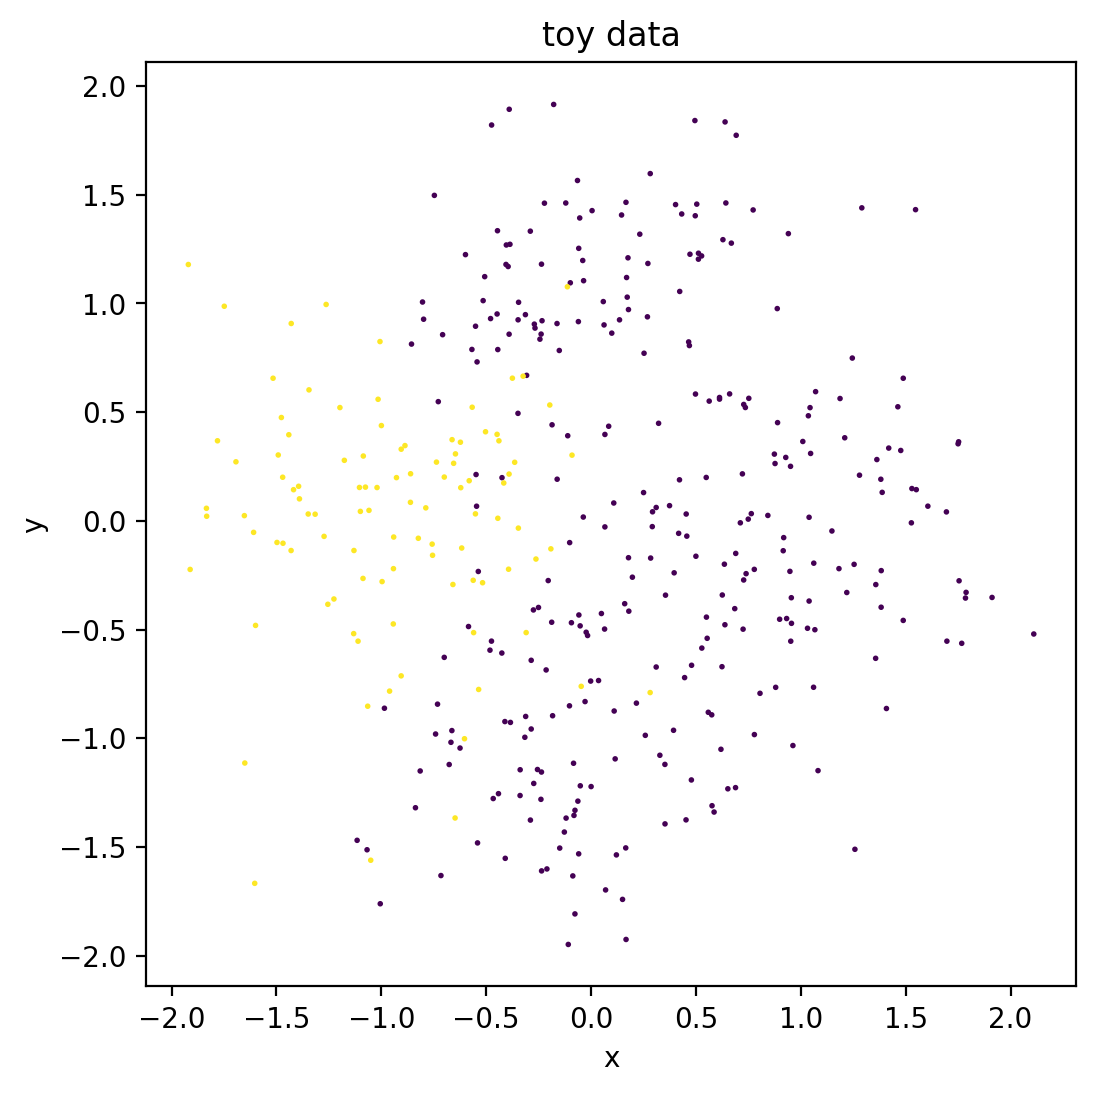

In [12]:
plt.figure(figsize=(6, 6))
plt.title("toy data")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(data[:, 0], data[:, 1], c=labels, s=1)
plt.show()

In [13]:
class toyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_dim = 2
        self.output_dim = 1
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, 3),
            nn.ReLU(),
            nn.Linear(3, 7),
            nn.ReLU(),
            nn.Linear(7, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, data):
        return self.model(data)
    
    def classify(self, data):
        with torch.no_grad():
            labels = torch.heaviside(2*self.model(data) - 1, torch.tensor([0.0])).to(torch.int)
        return labels

In [14]:
# Train the model
model = toyMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.BCELoss()
epochs = 1000

## Convert data to PyTorch tensors
data_tensor = torch.tensor(data, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(data_tensor)
    loss = loss_function(output, labels_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")
print(f"Final Loss = {loss.item()}")    

Epoch 0: Loss = 0.7550238966941833
Epoch 100: Loss = 0.36051636934280396
Epoch 200: Loss = 0.22733552753925323
Epoch 300: Loss = 0.1980707049369812
Epoch 400: Loss = 0.18639175593852997
Epoch 500: Loss = 0.17930717766284943
Epoch 600: Loss = 0.17547087371349335
Epoch 700: Loss = 0.1732407957315445
Epoch 800: Loss = 0.1710059493780136
Epoch 900: Loss = 0.16942380368709564
Final Loss = 0.1681738644838333


In [15]:
model_parameters = list(model.parameters())
weights1 = model_parameters[0].detach().numpy()
biases1 = model_parameters[1].detach().numpy()

print(weights1)
print(biases1)

[[ 0.2113915  -0.16707927]
 [ 0.8544633  -0.68624914]
 [ 0.7339891   1.1448122 ]]
[-0.6573023  0.7078591  0.2884745]


In [16]:
# converting the line equation into x and y values
## weight * data + bias = 0  => y_values = - (weight[0] * x_values + bias[0]) / weight[1]
y_value_equation = lambda weight, bias, x: - (weight[0] * x + bias) / weight[1]
x_value_equation = lambda weight, bias, y: - (weight[1] * y + bias) / weight[0]

def define_line(weight, bias, bounds):
    if np.isclose(weight[1], 0): # vertical line
        y = bounds
        x = x_value_equation(weight, bias, y) 
    else:
        x = bounds
        y = y_value_equation(weight, bias, x)

    return x, y

In [17]:
bound = 1.5
bounds = np.array([-bound, bound])
line_points = np.array([define_line(weight, bias, bounds) for weight, bias in zip(weights1, biases1)])
print(line_points)

[[[-1.5         1.5       ]
  [-5.8318998  -2.0362495 ]]

 [[-1.5         1.5       ]
  [-0.83619168  2.89917161]]

 [[-1.5         1.5       ]
  [ 0.7097314  -1.21369963]]]


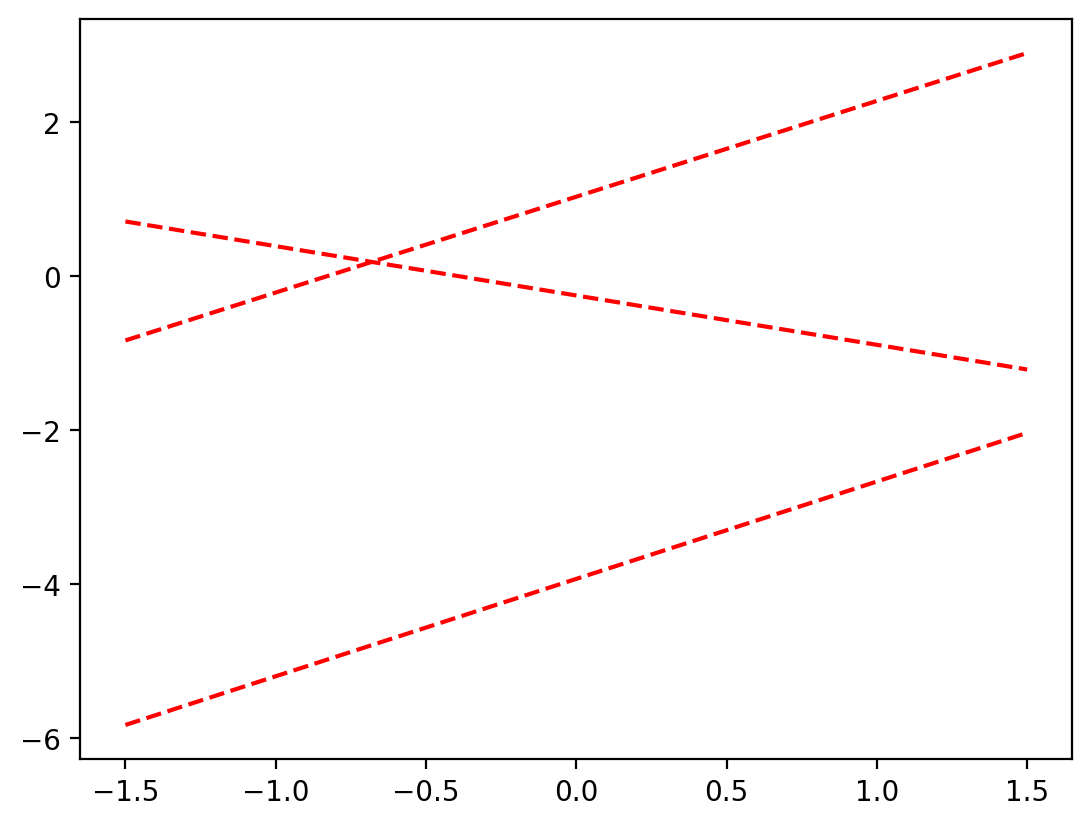

In [ ]:
for i in range(len(line_points)):
    plt.plot(line_points[i, 0], line_points[i, 1], 'r--', label='Decision Boundary')
    

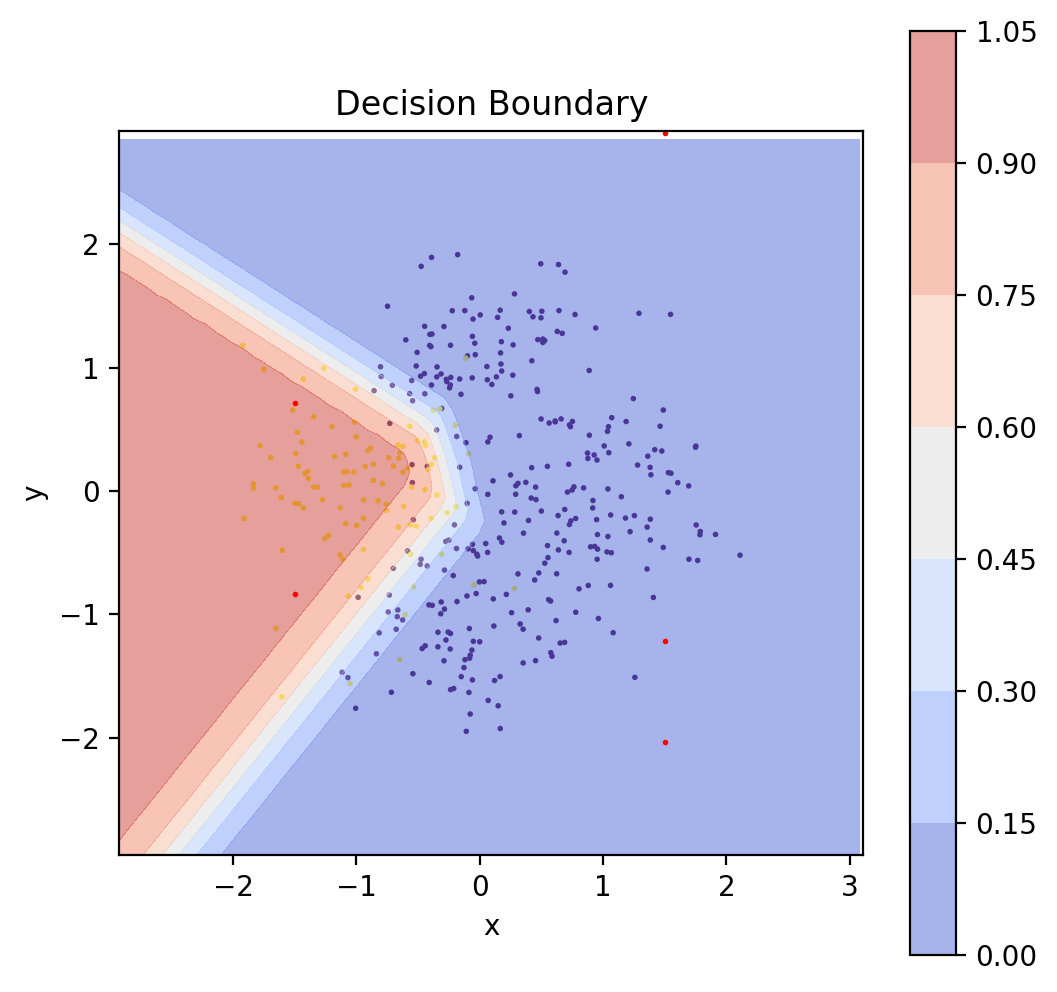

In [21]:
# make test grid
# create a grid of points to classify  
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
#print(f"xx shape: {xx.shape}, yy shape: {yy.shape}")

# convert grid points to tensor
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

labels_grid = model.forward(grid_points).detach().numpy()   # run the soft classification
labels_grid = labels_grid.reshape(xx.shape)   # reshape the labels to match the grid shape   

# plot the soft decision boundary
plt.figure(figsize=(6, 6))
plt.title("Decision Boundary")
plt.xlabel("x") 
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.gca().set_aspect('equal')
plt.scatter(data[:, 0], data[:, 1], c=labels, s=1)
plt.contourf(xx, yy, labels_grid, alpha=0.5, cmap='coolwarm')
plt.colorbar()
plt.scatter(line_points[:, 0], line_points[:, 1], c='red', s=1)
plt.show()